In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Load the data - Try specifying the encoding
# Common encodings to try include 'latin-1', 'cp1252'
try:
    df = pd.read_csv('/content/customer_booking.csv', encoding='latin-1')
except UnicodeDecodeError:
    # If 'latin-1' fails, try another common encoding like 'cp1252'
    df = pd.read_csv('/content/customer_booking.csv', encoding='cp1252')

# Initial exploration
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())

   num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0        

In [3]:
# Handle missing values if any (none in this dataset)
df = df.dropna()

# Convert categorical variables
cat_cols = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Convert boolean columns to binary
bool_cols = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
df[bool_cols] = df[bool_cols].astype(int)

# Check class distribution
print(df['booking_complete'].value_counts())

booking_complete
0    42522
1     7478
Name: count, dtype: int64


In [4]:
# Create new features if needed
# For example, we could create a 'total_services' feature
df['total_services'] = df['wants_extra_baggage'] + df['wants_preferred_seat'] + df['wants_in_flight_meals']

# Or categorize purchase_lead into bins
df['purchase_lead_category'] = pd.cut(df['purchase_lead'],
                                    bins=[0, 7, 30, 90, 365, np.inf],
                                    labels=['last_minute', 'short', 'medium', 'long', 'very_long'])

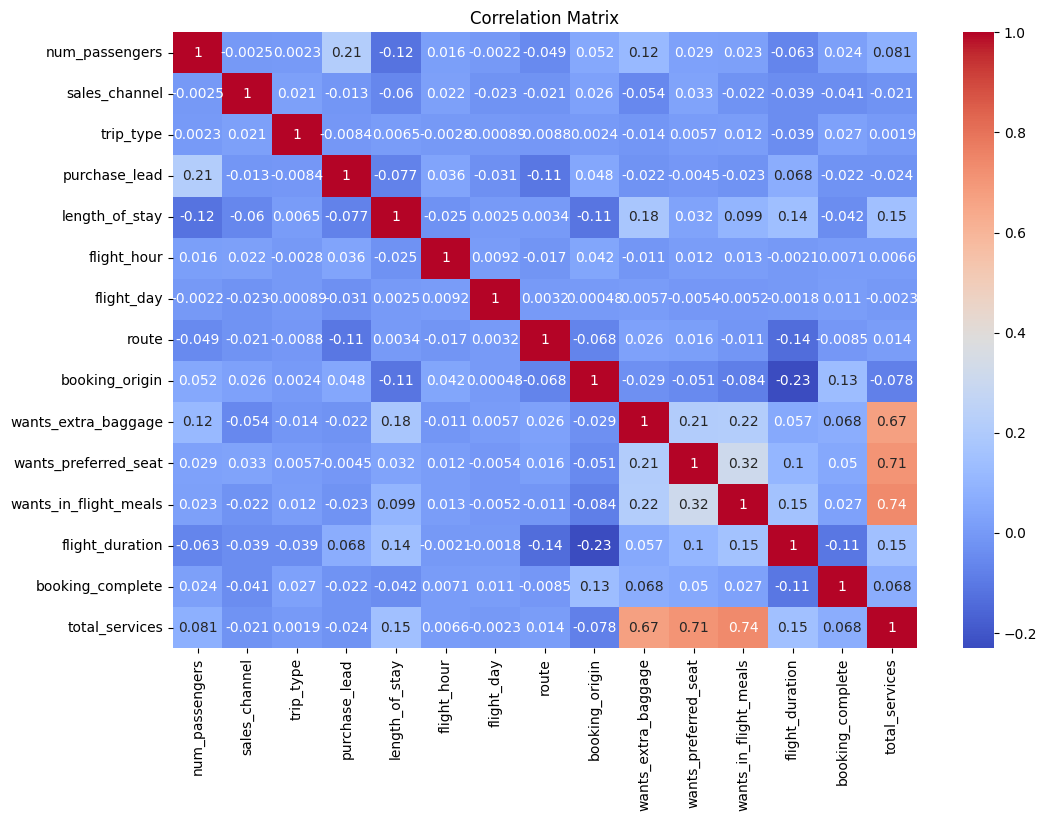

In [6]:
# Select features and target
X = df.drop(['booking_complete', 'purchase_lead_category'], axis=1)  # drop target and temporary features
y = df['booking_complete']

# Correlation analysis
# Drop the 'purchase_lead_category' column before calculating correlation
corr_matrix = df.drop('purchase_lead_category', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Class distribution in training set: {y_train.value_counts(normalize=True)}")
print(f"Class distribution in test set: {y_test.value_counts(normalize=True)}")

Training set size: (35000, 14)
Test set size: (15000, 14)
Class distribution in training set: booking_complete
0    0.850429
1    0.149571
Name: proportion, dtype: float64
Class distribution in test set: booking_complete
0    0.850467
1    0.149533
Name: proportion, dtype: float64


In [8]:
# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

Accuracy: 0.8514666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92     12757
           1       0.52      0.10      0.17      2243

    accuracy                           0.85     15000
   macro avg       0.69      0.54      0.54     15000
weighted avg       0.81      0.85      0.81     15000


Confusion Matrix:
 [[12545   212]
 [ 2016   227]]

Feature Importances:
                        importance
purchase_lead            0.189672
route                    0.150135
flight_hour              0.138927
length_of_stay           0.127649
booking_origin           0.109297
flight_day               0.089956
flight_duration          0.074276
num_passengers           0.048687
total_services           0.023594
wants_in_flight_meals    0.013552
sales_channel            0.011207
wants_preferred_seat     0.010879
wants_extra_baggage      0.010541
trip_type                0.001627


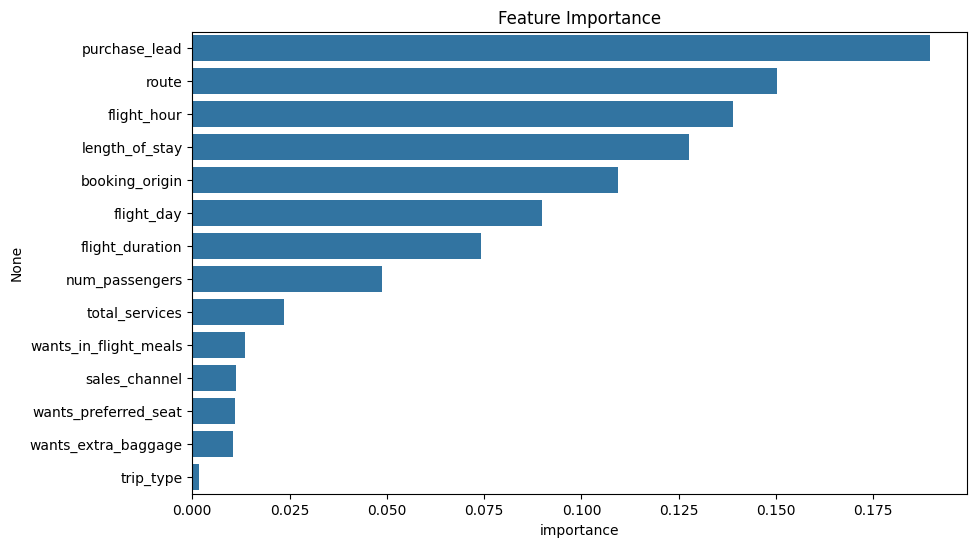

In [9]:
# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print("\nFeature Importances:\n", feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=5, n_jobs=-1, verbose=2, scoring='f1')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
print("\nOptimized Model Classification Report:\n", classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Train final model with best parameters
final_rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)
final_rf.fit(X_train, y_train)

